In [ ]:
## Collects monthly sum of VIIRS Nighttime Lights data
"""
Data Source: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG (Earth Observation Group, Payne Institute for Public Policy)
GEE Dataset: https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG

the FAO Global Administrative Unit Layers (GAUL) to define the country's land boundary.

To use GEE, separate authentication and initialization are required.
(See https://developers.google.com/earth-engine/python_install)

"""

# Import GEE and initialize
import ee
import datetime
import csv
import sys # To handle potential errors

# --- Authenticate and Initialize GEE ---
# This needs to be done once per session.
try:
    ee.Authenticate()
    # Replace project name with your own GEE project name if necessary.
    ee.Initialize(project='your-project-name')  # Replace with your GEE project name
except ee.EEException as e:
    print(f"GEE initialization error: {e}")
    print("Please ensure you have authenticated and set up a GEE project.")
    sys.exit(1)

/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Search for available country names in the FAO GAUL dataset
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
country_names = countries.aggregate_array('ADM0_NAME').getInfo()

country_names.sort()
for name in country_names:
    print(name)

# Example search for names containing 'United'
for name in country_names:
    if 'United' in name:
        print(name)

Abyei
Afghanistan
Aksai Chin
Albania
Algeria
American Samoa
Andorra
Angola
Anguilla
Antarctica
Antigua and Barbuda
Argentina
Armenia
Aruba
Arunachal Pradesh
Ashmore and Cartier Islands
Australia
Australia
Australia
Austria
Azerbaijan
Azores Islands
Bahamas
Bahrain
Baker Island
Bangladesh
Barbados
Bassas da India
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bird Island
Bolivia
Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
China/India
Christmas Island
Clipperton Island
Cocos (Keeling) Islands
Colombia
Comoros
Congo
Cook Islands
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Côte d'Ivoire
Dem People's Rep of Korea
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Gui

In [7]:
# --- (1) Define Parameters ---

# CHOOSE THE COUNTRY: Use the exact name from the FAO GAUL dataset.
country_name = "U.K. of Great Britain and Northern Ireland"

# List of years for analysis
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# --- (2) Get Country Boundary (Area of Interest) ---
# Load the feature collection for country boundaries.
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")

# Filter the collection to get the specific country feature.
country = countries.filter(ee.Filter.eq('ADM0_NAME', country_name)).first()

# Check if the country was found
if not country.getInfo():
    print(f"Error: Country '{country_name}' not found. Please check the spelling.")
    sys.exit(1)

# The geometry of the feature is the region of interest.
region = country.geometry()
print(f"Successfully loaded the boundary for: {country_name}")


# --- (3) Collect Data ---

# Dictionary to store monthly sum of lights values
sum_of_lights_values = {}

print(f"\nStarting monthly data collection for {country_name}...")

# Loop over each year and month
for year in years:
    for month in range(1, 13):
        # Define start and end dates for the month
        start_date = f"{year}-{month:02d}-01"
        
        # Move to the next month to define the end date
        next_month_year = year
        next_month = month + 1
        if month == 12:
            next_month_year = year + 1
            next_month = 1
        end_date = f"{next_month_year}-{next_month:02d}-01"
        
        # Filter the monthly composite data collection by date and region
        collection = (ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
                      .filterBounds(region)
                      .filterDate(start_date, end_date))
        
        # Check if data is available for the month
        count = collection.size().getInfo()
        if count == 0:
            print(f"{year}-{month:02d}: No data available.")
            sum_of_lights_values[f"{year}-{month:02d}"] = 'NoData'
            continue
        
        # Create a single composite image for the month and clip it to the AOI
        # Using median() is still a good practice to create a stable monthly composite from daily images if available
        composite = collection.median().clip(region)
        
        # Select the 'avg_rad' band (radiance in nW/cm²/sr)
        # and set negative values to 0, as negative radiance is not physical.
        lights = composite.select('avg_rad').max(0)
        
        # Compute the SUM of lights within the region
        # Scale is the spatial resolution in meters. VIIRS is approx. 500m.
        stats = lights.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=500,
            maxPixels=1e10  # Increased maxPixels for large countries
        )
        
        # Extract the sum of lights value
        sum_of_lights = stats.getInfo().get('avg_rad', None)
        sum_of_lights_values[f"{year}-{month:02d}"] = sum_of_lights
        print(f"{year}-{month:02d}: Sum of Lights = {sum_of_lights}")

# --- (4) Save Results to CSV ---
country_name_for_file = country_name.replace(" ", "_")
output_filename = f'VIIRS_SumOfLights_Monthly_{country_name_for_file}_{years[0]}-{years[-1]}.csv'

with open(output_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['month', 'sum_of_lights']) # Changed header
    for month_key in sorted(sum_of_lights_values.keys()):
        writer.writerow([month_key, sum_of_lights_values[month_key]])

print(f"\nMonthly Sum of Lights results for {country_name} have been saved to '{output_filename}'.")

Successfully loaded the boundary for: U.K. of Great Britain and Northern Ireland

Starting monthly data collection for U.K. of Great Britain and Northern Ireland...
2012-01: No data available.
2012-02: No data available.
2012-03: No data available.
2012-04: No data available.
2012-05: No data available.
2012-06: No data available.
2012-07: No data available.
2012-08: No data available.
2012-09: No data available.
2012-10: No data available.
2012-11: No data available.
2012-12: No data available.
2013-01: No data available.
2013-02: No data available.
2013-03: No data available.
2013-04: No data available.
2013-05: No data available.
2013-06: No data available.
2013-07: No data available.
2013-08: No data available.
2013-09: No data available.
2013-10: No data available.
2013-11: No data available.
2013-12: No data available.
2014-01: Sum of Lights = 3259869.0220996016
2014-02: Sum of Lights = 3491196.4187005125
2014-03: Sum of Lights = 3188099.3400875526
2014-04: Sum of Lights = 302299

In [2]:
# Load necessary libraries
import os, random
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller    # For ADF test
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras                      # TensorFlow does not support Python 3.12 yet (as of June 2025)
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
## Algorithm 1 & 2: Data Preparation and Quarterly Aggregation of Variables

# 1. Load the master dataset
df = pd.read_csv('master_UK_VIIRS.csv')

# 2. Parse the DATE column and create a quarter identifier
df['DATE'] = pd.to_datetime(df['DATE'])
df['quarter'] = df['DATE'].dt.to_period('Q')

# 3. Specify the target variable name
Y_col = 'Real GDP' 

# 5. Identify explanatory variables (exclude DATE, quarter, and Y column)
exclude_cols = {'DATE', 'quarter', Y_col}
x_cols = [col for col in df.columns if col not in exclude_cols]

# 6. Run ADF test for each explanatory variable
adf_results = pd.DataFrame(columns=["Variable", "ADF Statistic", "p-value", "Stationary at 5%"])
X_prime_m_df = df[['DATE', 'quarter']].copy()  # To store transformed monthly variables

for col in x_cols:
    series_original = df[col].copy()
    series_numeric = pd.to_numeric(series_original, errors='coerce').dropna()

    if not series_numeric.empty:
        result = adfuller(series_numeric)
        adf_stat = result[0]
        p_value = result[1]
        is_stationary = p_value < 0.05
        adf_results.loc[len(adf_results)] = [col, adf_stat, p_value, is_stationary]
    else:
        adf_results.loc[len(adf_results)] = [col, np.nan, np.nan, False]

# Display ADF test results
adf_results_display = adf_results.set_index("Variable").sort_values("p-value")
print("\n=== ADF Test Results ===")
print(adf_results_display)



=== ADF Test Results ===
                ADF Statistic   p-value  Stationary at 5%
Variable                                                 
Prod_Vol            -3.091954  0.027154              True
Unemp               -2.906911  0.044550              True
Total Reserves      -2.540891  0.105839             False
Emp                 -2.500778  0.115285             False
^FTSE               -2.486461  0.118803             False
Share_Prices        -2.469807  0.122994             False
Exchange            -2.326644  0.163519             False
Exports             -1.920010  0.322707             False
VIIRS               -1.908354  0.328141             False
Intr_Rate           -1.659148  0.452274             False
Intr_10Y            -1.659148  0.452274             False
Imports             -1.629154  0.467934             False
M1                  -1.345656  0.608035             False
CPI                 -0.163826  0.942698             False


/var/folders/1b/b3lsjhy10fsd753tw_292d5w0000gn/T/ipykernel_17902/1192590155.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


In [10]:
# 7. Manually specify which X columns should be log-differenced
log_diff_cols = [
'Unemp',              
'Intr_10Y',            
'Intr_Rate',           
'Exchange',            
'Prod_Vol',            
'Emp',                
'Share_Prices',        
'^FTSE',               
'Exports',            
'Imports',            
'Total Reserves',     
'M1',                   
'CPI',
'VIIRS'
]

# 8. Identify explanatory variables that are not log-differenced
non_log_cols = [col for col in x_cols if col not in log_diff_cols]

# 9. Apply transformation to create X_prime_m_df (transformed monthly X)
for col in x_cols:
    if col in log_diff_cols:
        if (df[col] <= 0).any():
            print(f"Warning: Column {col} contains non-positive values. Applying log.diff() may result in NaNs or errors.")
            try:
                X_prime_m_df[col] = np.log(df[col].replace(0, np.nan)).diff()
            except Exception as e:
                print(f"Error log-differencing {col}: {e}. Column will be NaN.")
                X_prime_m_df[col] = np.nan
        else:
            X_prime_m_df[col] = np.log(df[col]).diff()
    else:
        X_prime_m_df[col] = df[col].copy()


# 10. Group the transformed monthly X by quarter
quarter_groups_X_prime = X_prime_m_df.groupby('quarter')

# 11. For log-differenced variables, take the quarterly sum
x_q_aggregated_log = quarter_groups_X_prime[log_diff_cols].sum() if log_diff_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 12. For non-log-differenced variables, take the quarterly mean
x_q_aggregated_nonlog = quarter_groups_X_prime[non_log_cols].mean() if non_log_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 13. Combine aggregated quarterly explanatory variables
X_q_aggregated = pd.concat([x_q_aggregated_log, x_q_aggregated_nonlog], axis=1).sort_index()

# 14. Extract quarterly target observations (use the first month of each quarter)
y_q_levels_df = (
    df[df[Y_col].notna()][['quarter', Y_col]]
    .drop_duplicates(subset='quarter', keep='first')    # Ensure we take the first month of each quarter
    .set_index('quarter')
    .sort_index()
)

# 15. Align aggregated X with quarterly Y
common_index = X_q_aggregated.index.intersection(y_q_levels_df.index)
X_q_aligned = X_q_aggregated.loc[common_index]
Y_q_levels = y_q_levels_df.loc[common_index, Y_col]

# 16. Convert Y to quarterly log difference (growth rate)
Y_q_processed = np.log(Y_q_levels).diff().dropna()

# 17. Align X again with the log-differenced Y (drops one more quarter)
X_q_processed = X_q_aligned.loc[Y_q_processed.index]

# Display
print("\n--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---")
print("Processed Quarterly X shape:", X_q_processed.shape)
print("Processed Quarterly Y shape:", Y_q_processed.shape)
print("\nX_q_processed (first few rows):")
print(X_q_processed.head())
print("\nY_q_processed (first few rows):")
print(Y_q_processed.head())


--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---
Processed Quarterly X shape: (40, 14)
Processed Quarterly Y shape: (40,)

X_q_processed (first few rows):
            Unemp  Intr_10Y  Intr_Rate  Exchange  Prod_Vol       Emp  \
quarter                                                                
2014Q2  -0.078781  0.000180   0.000180  0.016939  0.002225  0.001375   
2014Q3  -0.033336 -0.110915  -0.110915 -0.037235  0.013245  0.002743   
2014Q4  -0.052186 -0.256199  -0.256199 -0.040464  0.018469  0.004101   
2015Q1  -0.018019 -0.072343  -0.072343 -0.044841  0.017076  0.001363   
2015Q2   0.000000  0.190039   0.190039  0.040485  0.010527  0.001361   

         Share_Prices     ^FTSE   Exports   Imports  Total Reserves        M1  \
quarter                                                                         
2014Q2       0.025696  0.025696 -0.054171  0.002904        0.014638  0.013282   
2014Q3      -0.003911 -0.003911  0.013996  0.011625       -0.04741

In [11]:
## Algorithm 3: Neural Network Hyperparameter Optimization

# Set Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 1. Split the data into training and test sets (80/20 split)
split_idx = int(len(X_q_processed) * 0.8)
X_q_train = X_q_processed.iloc[:split_idx]
Y_q_train = Y_q_processed.iloc[:split_idx]
X_q_test = X_q_processed.iloc[split_idx:]
Y_q_test = Y_q_processed.iloc[split_idx:]

# 2. Standardize non-log-differenced columns
scaler = StandardScaler()    # Z-score
X_q_train_scaled = X_q_train.copy()
X_q_test_scaled = X_q_test.copy()
if non_log_cols:
    X_q_train_scaled[non_log_cols] = scaler.fit_transform(X_q_train[non_log_cols])  # For training data, fit the scaler
    X_q_test_scaled[non_log_cols] = scaler.transform(X_q_test[non_log_cols])        # For test data, we do not fit again, just transform to avid data leakage

# Sign accuracy funtion
def sign_acc_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32))

# 3. KerasTuner funtion
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_q_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 7)):  # up to 5 layers (may increase for more complexity)
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=8, max_value=700, step=10),
                activation=hp.Choice('activation', ['relu', 'tanh', 'elu', 'selu', 'swish'])
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)
            )
        )
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(         # Adam optimizer
            learning_rate=hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
        ),
        loss='mse',
        metrics=['mse', sign_acc_metric]
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mse',
    max_trials=350,                              # Increase trials for better search
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='gdp_q_nn_wide'
)

tuner.search(
    X_q_train_scaled.values, Y_q_train.values,
    epochs=2000,
    batch_size=4,
    validation_data=(X_q_test_scaled.values, Y_q_test.values),
    callbacks=[keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)],
    verbose=2
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n[Best Hyperparameters]")
for k,v in best_hp.values.items():
    print(f"{k}: {v}")

Trial 350 Complete [00h 01m 17s]
val_mse: 0.00014163507148623466

Best val_mse So Far: 5.467808932735352e-06
Total elapsed time: 04h 00m 20s

[Best Hyperparameters]
num_layers: 7
units_0: 558
activation: relu
dropout_0: 0.0
lr: 0.0001
units_1: 8
dropout_1: 0.45
units_2: 698
dropout_2: 0.45
units_3: 8
dropout_3: 0.0
units_4: 698
dropout_4: 0.0
units_5: 698
dropout_5: 0.0
units_6: 8
dropout_6: 0.2


/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


2025-06-25 20:21:52.769071: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-25 20:21:52.770155: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


[Model Evaluation on Test Set]
Test MSE: 0.000005
Test RMSE: 0.002338
Test MAE: 0.002051
Test R²: 0.460
Sign Accuracy: 75.00%
sMAPE: 129.24%
Theil's U1: 0.341

'test_MLP_UK_VIIRS.csv' saved.
'test_MLP_UK_VIIRS_summary_metrics.csv' saved.


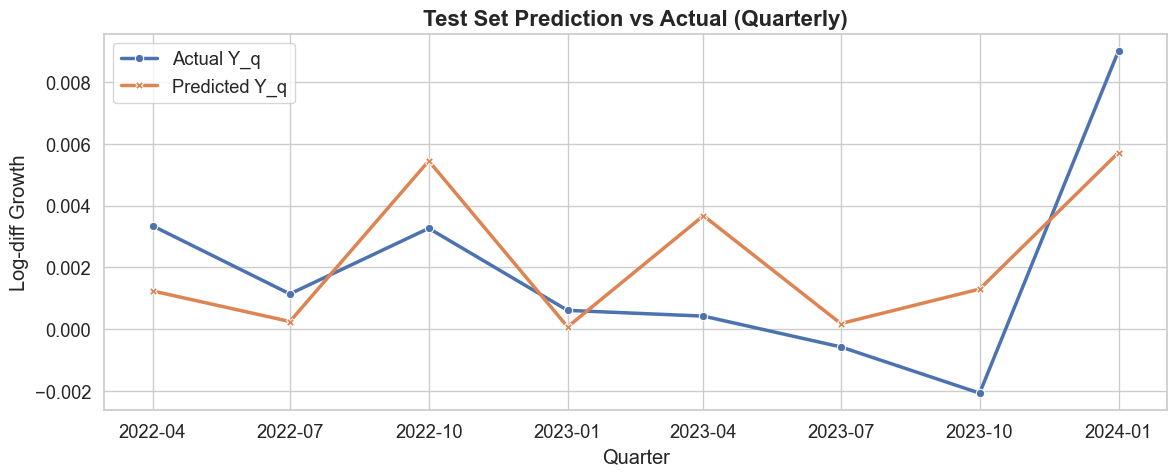

In [12]:
# 5. Quarterly Prediction and Evaluation
y_test_pred = best_model.predict(X_q_test_scaled.values).flatten()

# Define functions for sMAPE and Theil's U1
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)
    return np.mean(ratio) * 100

def theil_u1(y_true, y_pred):
    """Theil's U1 statistic for forecast accuracy"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rms_actual = np.sqrt(np.mean(y_true**2))
    rms_pred = np.sqrt(np.mean(y_pred**2))
    if (rms_actual + rms_pred) == 0:
        return np.nan
    return rmse / (rms_actual + rms_pred)

# Calculate all metrics
mse = mean_squared_error(Y_q_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_q_test, y_test_pred)
r2 = r2_score(Y_q_test, y_test_pred)
sign_acc = (np.sign(y_test_pred) == np.sign(Y_q_test)).mean()
smape_val = smape(Y_q_test, y_test_pred)
theil_u1_val = theil_u1(Y_q_test, y_test_pred)

# Print all metrics
print("\n[Model Evaluation on Test Set]")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²: {r2:.3f}")
print(f"Sign Accuracy: {sign_acc:.2%}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"Theil's U1: {theil_u1_val:.3f}")


# Create a DataFrame for per-prediction results
results_index = Y_q_test.index
results_df = pd.DataFrame({
    "Quarter": results_index.to_timestamp(),
    "Actual_Y_q": Y_q_test,
    "Predicted_Y_q": y_test_pred,
    "Sign_Match": (np.sign(y_test_pred) == np.sign(Y_q_test)).astype(int)
})
results_df.to_csv("test_MLP_UK_VIIRS.csv", index=False)
print("\n'test_MLP_UK_VIIRS.csv' saved.")

# Create and save a DataFrame for the summary metrics
metrics_summary_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Sign Accuracy', 'sMAPE', 'Theil U1'],
    'Value': [mse, rmse, mae, r2, sign_acc, smape_val, theil_u1_val]
})
metrics_summary_df.to_csv("test_MLP_UK_VIIRS_summary_metrics.csv", index=False)
print("'test_MLP_UK_VIIRS_summary_metrics.csv' saved.")

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 5))
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=Y_q_test.values, label="Actual Y_q", marker="o")
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test_pred, label="Predicted Y_q", marker="X")

plt.title("Test Set Prediction vs Actual (Quarterly)", fontsize=16, weight='bold')
plt.xlabel("Quarter")
plt.ylabel("Log-diff Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# 6. Monthly GDP prediction with reconciliation (Proportional Denton)

# Monthly X scaling (matching columns and order used in model training)
X_m_scaled = X_prime_m_df[X_q_train.columns].copy()
if non_log_cols:
    X_m_scaled[non_log_cols] = scaler.transform(X_m_scaled[non_log_cols])

# Monthly "quarterly-perspective" growth prediction
monthly_y_pred_nn = best_model.predict(X_m_scaled.values).flatten()
monthly_predictions_df = pd.DataFrame({
    'raw_quarterly_log_diff_pred': monthly_y_pred_nn
}, index=X_prime_m_df['DATE'])
monthly_predictions_df.index = pd.to_datetime(monthly_predictions_df.index)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# Naive monthly growth: simply distribute predicted quarterly growth equally to each month
monthly_predictions_df['naive_monthly_log_diff'] = monthly_predictions_df['raw_quarterly_log_diff_pred'] / 3.0

# Actual observed quarterly log growth (Y_q_processed)
actual_quarterly_log_diffs = Y_q_processed.copy()
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# For each quarter, calculate scaling factor so the sum of naive monthly growths matches actual quarterly growth
quarterly_sum_of_naive = monthly_predictions_df.groupby('quarter')['naive_monthly_log_diff'].sum()
adjusted_monthly_log_diffs = pd.Series(index=monthly_predictions_df.index, dtype=float)

for quarter, group in monthly_predictions_df.groupby('quarter'):
    if quarter in actual_quarterly_log_diffs.index and quarter in quarterly_sum_of_naive.index:
        actual_q_log_diff = actual_quarterly_log_diffs.loc[quarter]
        sum_naive = quarterly_sum_of_naive.loc[quarter]
        if sum_naive != 0:
            adjustment_factor = actual_q_log_diff / sum_naive
            adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff'] * adjustment_factor
        else:
            # If sum_naive is zero, evenly distribute actual growth across the months in the quarter
            adjusted_monthly_log_diffs.loc[group.index] = actual_q_log_diff / len(group)
    else:
        # If we have no actual value, just use the naive value
        adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff']

monthly_predictions_df['adjusted_monthly_log_diff'] = adjusted_monthly_log_diffs

# Export predicted monthly GDP growth as CSV
mgdp_pred_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff']
}, index=monthly_predictions_df.index)
mgdp_pred_df.index.name = "DATE"
mgdp_pred_df.to_csv("UK_monthly_GDP_MLP_VIIRS_growth.csv")
print("UK_monthly_GDP_MLP_VIIRS_growth.csv saved")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
UK_monthly_GDP_MLP_VIIRS_growth.csv saved


2025-06-25 20:22:02.759863: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-25 20:22:02.760209: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

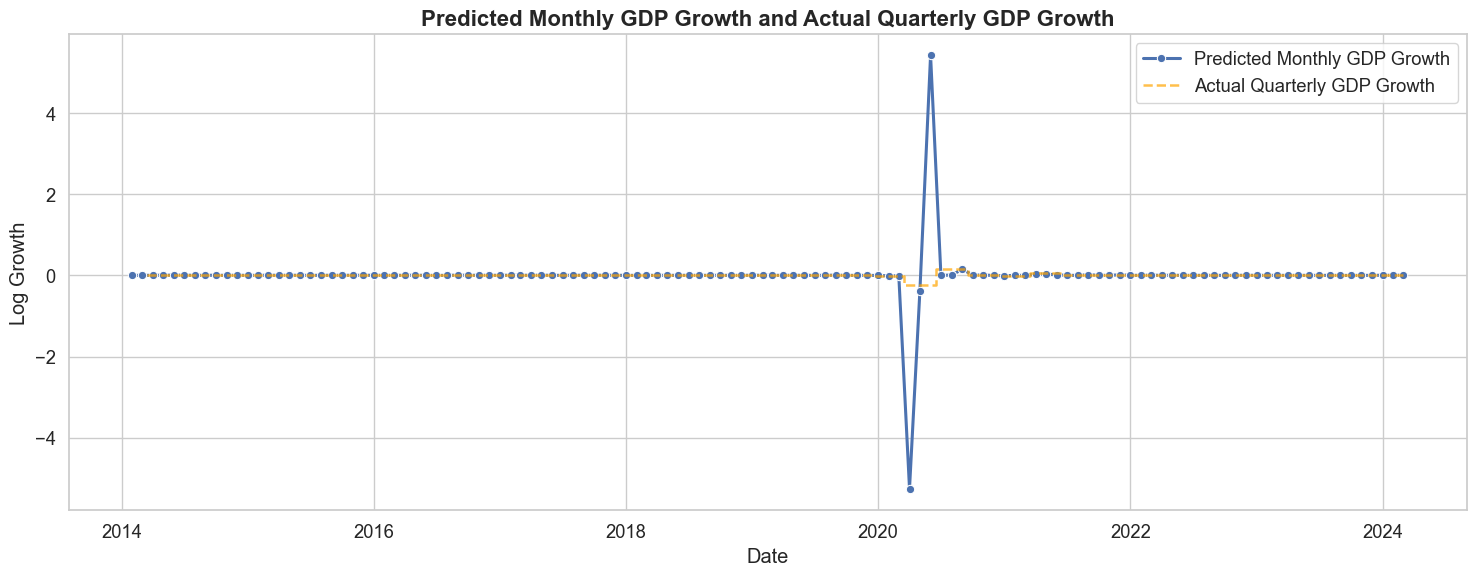

In [14]:
# Plotting Predicted Monthly GDP Growth vs Actual Quarterly GDP Growth
monthly_pred = monthly_predictions_df['adjusted_monthly_log_diff']
quarter_to_growth = actual_quarterly_log_diffs
monthly_actual = monthly_predictions_df['quarter'].map(quarter_to_growth)

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_pred.index, y=monthly_pred.values, label="Predicted Monthly GDP Growth", marker='o', linewidth=2.2)
plt.step(monthly_actual.index, monthly_actual.values, label="Actual Quarterly GDP Growth",
         where='mid', linestyle='--', color='orange', linewidth=1.8, alpha=0.7)

plt.title("Predicted Monthly GDP Growth and Actual Quarterly GDP Growth", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Log Growth")
plt.legend()
plt.tight_layout()
plt.show()

Base quarter not found. Using the first available GDP level 2014Q1: 554183.0
Final quarterly comparison results:
            Actual_Quarterly_Level  ReAgg_Monthly_Level
quarter                                                
2014-01-01                554183.0        554183.000000
2014-04-01                559331.0        555236.308970
2014-07-01                563694.0        562786.895697
2014-10-01                567619.0        565374.138585
2015-01-01                569150.0        567075.128310

R²: -4.9065, MSE: 5781749878.97


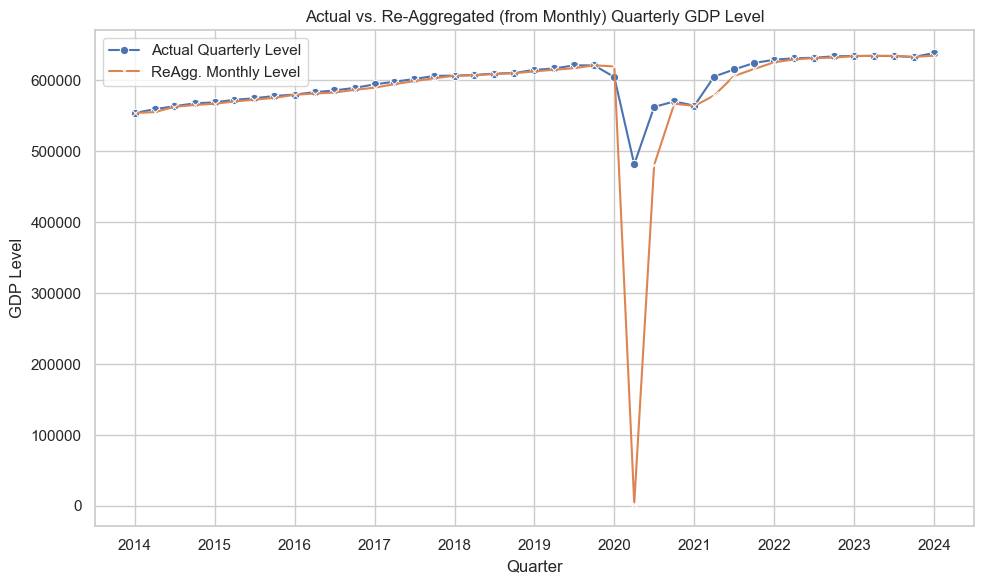

UK_monthly_GDP_MLP_VIIRS_growth_level.csv saved!


In [15]:
# 7. Recover Monthly Level

# Find the first valid index (start month) for growth reconstruction
first_valid_month_idx = monthly_predictions_df['adjusted_monthly_log_diff'].first_valid_index()
first_quarter = monthly_predictions_df.loc[first_valid_month_idx, 'quarter']
base_level_quarter = first_quarter - 1

# Set base_level as the previous quarter's GDP level
if base_level_quarter in Y_q_levels.index:
    base_level = Y_q_levels.loc[base_level_quarter]
    print(f"Using GDP level of base quarter {base_level_quarter} as base_level: {base_level}")
else:
    base_level = Y_q_levels.iloc[0]
    print(f"Base quarter not found. Using the first available GDP level {Y_q_levels.index[0]}: {base_level}")

# Recover monthly GDP levels from growth (starting from the first valid growth)
reconstructed_levels = {}
current_level = base_level
for i, month in enumerate(monthly_predictions_df.index):
    if month < first_valid_month_idx:
        reconstructed_levels[month] = np.nan
    elif month == first_valid_month_idx:
        reconstructed_levels[month] = current_level
    else:
        log_diff = monthly_predictions_df.loc[month, 'adjusted_monthly_log_diff']
        if pd.isna(log_diff):
            reconstructed_levels[month] = np.nan
        else:
            prev_month = monthly_predictions_df.index[monthly_predictions_df.index.get_loc(month) - 1]
            prev_level = reconstructed_levels[prev_month]
            if pd.isna(prev_level):
                reconstructed_levels[month] = np.nan
            else:
                reconstructed_levels[month] = prev_level * np.exp(log_diff)
monthly_predictions_df['reconstructed_monthly_level'] = pd.Series(reconstructed_levels)


# Aggregate to Quarterly Level & Compare with Actual (using first month of each quarter)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')
re_agg_quarterly = (
    monthly_predictions_df
    .groupby('quarter')['reconstructed_monthly_level']
    .first()
)

# Convert index to Timestamp for plotting
re_agg_quarterly_ts = re_agg_quarterly.copy()
re_agg_quarterly_ts.index = re_agg_quarterly_ts.index.to_timestamp(how='start')
Y_q_levels_ts = Y_q_levels.copy()
Y_q_levels_ts.index = Y_q_levels_ts.index.to_timestamp(how='start')

comparison_df = pd.DataFrame({
    'Actual_Quarterly_Level': Y_q_levels_ts,
    'ReAgg_Monthly_Level': re_agg_quarterly_ts
}).dropna()

print("Final quarterly comparison results:")
print(comparison_df.head())
print("\nR²: %.4f, MSE: %.2f" % (
    r2_score(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level']),
    mean_squared_error(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level'])
))


# Plot 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(x=comparison_df.index, y=comparison_df['Actual_Quarterly_Level'], marker='o', label='Actual Quarterly Level')
sns.lineplot(x=comparison_df.index, y=comparison_df['ReAgg_Monthly_Level'], marker='x', label='ReAgg. Monthly Level')
plt.title("Actual vs. Re-Aggregated (from Monthly) Quarterly GDP Level")
plt.xlabel("Quarter")
plt.ylabel("GDP Level")
plt.legend()
plt.tight_layout()
plt.show()


# Save monthly GDP growth and level to CSV
out_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff'],
    "MGDP_level_pred": monthly_predictions_df['reconstructed_monthly_level']
}, index=monthly_predictions_df.index)
out_df.index.name = "DATE"
out_df.to_csv("UK_monthly_GDP_MLP_VIIRS_growth_level.csv")
print("UK_monthly_GDP_MLP_VIIRS_growth_level.csv saved!")

### VIIR Only case

In [3]:
## Algorithm 1 & 2: Data Preparation and Quarterly Aggregation of Variables

# 1. Load the master dataset
df = pd.read_csv('master_UK_VIIRS.csv')
df = df[['DATE', 'Real GDP', 'VIIRS']]  # only retain these three

# 2. Parse the DATE column and create a quarter identifier
df['DATE'] = pd.to_datetime(df['DATE'])
df['quarter'] = df['DATE'].dt.to_period('Q')

# 3. Specify the target variable name
Y_col = 'Real GDP' 

# 5. Identify explanatory variables (exclude DATE, quarter, and Y column)
exclude_cols = {'DATE', 'quarter', Y_col}
x_cols = [col for col in df.columns if col not in exclude_cols]

# 6. Run ADF test for each explanatory variable
adf_results = pd.DataFrame(columns=["Variable", "ADF Statistic", "p-value", "Stationary at 5%"])
X_prime_m_df = df[['DATE', 'quarter']].copy()  # To store transformed monthly variables

for col in x_cols:
    series_original = df[col].copy()
    series_numeric = pd.to_numeric(series_original, errors='coerce').dropna()

    if not series_numeric.empty:
        result = adfuller(series_numeric)
        adf_stat = result[0]
        p_value = result[1]
        is_stationary = p_value < 0.05
        adf_results.loc[len(adf_results)] = [col, adf_stat, p_value, is_stationary]
    else:
        adf_results.loc[len(adf_results)] = [col, np.nan, np.nan, False]

# Display ADF test results
adf_results_display = adf_results.set_index("Variable").sort_values("p-value")
print("\n=== ADF Test Results ===")
print(adf_results_display)


=== ADF Test Results ===
          ADF Statistic   p-value  Stationary at 5%
Variable                                           
VIIRS         -1.908354  0.328141             False


/var/folders/1b/b3lsjhy10fsd753tw_292d5w0000gn/T/ipykernel_26492/3171886584.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


In [4]:
# 7. Manually specify which X columns should be log-differenced
log_diff_cols = ['VIIRS']

# 8. Identify explanatory variables that are not log-differenced
non_log_cols = [col for col in x_cols if col not in log_diff_cols]

# 9. Apply transformation to create X_prime_m_df (transformed monthly X)
for col in x_cols:
    if col in log_diff_cols:
        if (df[col] <= 0).any():
            print(f"Warning: Column {col} contains non-positive values. Applying log.diff() may result in NaNs or errors.")
            try:
                X_prime_m_df[col] = np.log(df[col].replace(0, np.nan)).diff()
            except Exception as e:
                print(f"Error log-differencing {col}: {e}. Column will be NaN.")
                X_prime_m_df[col] = np.nan
        else:
            X_prime_m_df[col] = np.log(df[col]).diff()
    else:
        X_prime_m_df[col] = df[col].copy()


# 10. Group the transformed monthly X by quarter
quarter_groups_X_prime = X_prime_m_df.groupby('quarter')

# 11. For log-differenced variables, take the quarterly sum
x_q_aggregated_log = quarter_groups_X_prime[log_diff_cols].sum() if log_diff_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 12. For non-log-differenced variables, take the quarterly mean
x_q_aggregated_nonlog = quarter_groups_X_prime[non_log_cols].mean() if non_log_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 13. Combine aggregated quarterly explanatory variables
X_q_aggregated = pd.concat([x_q_aggregated_log, x_q_aggregated_nonlog], axis=1).sort_index()

# 14. Extract quarterly target observations (use the first month of each quarter)
y_q_levels_df = (
    df[df[Y_col].notna()][['quarter', Y_col]]
    .drop_duplicates(subset='quarter', keep='first')    # Ensure we take the first month of each quarter
    .set_index('quarter')
    .sort_index()
)

# 15. Align aggregated X with quarterly Y
common_index = X_q_aggregated.index.intersection(y_q_levels_df.index)
X_q_aligned = X_q_aggregated.loc[common_index]
Y_q_levels = y_q_levels_df.loc[common_index, Y_col]

# 16. Convert Y to quarterly log difference (growth rate)
Y_q_processed = np.log(Y_q_levels).diff().dropna()

# 17. Align X again with the log-differenced Y (drops one more quarter)
X_q_processed = X_q_aligned.loc[Y_q_processed.index]

# Display
print("\n--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---")
print("Processed Quarterly X shape:", X_q_processed.shape)
print("Processed Quarterly Y shape:", Y_q_processed.shape)
print("\nX_q_processed (first few rows):")
print(X_q_processed.head())
print("\nY_q_processed (first few rows):")
print(Y_q_processed.head())


--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---
Processed Quarterly X shape: (40, 1)
Processed Quarterly Y shape: (40,)

X_q_processed (first few rows):
            VIIRS
quarter          
2014Q2   0.272146
2014Q3  -0.148808
2014Q4   0.004540
2015Q1  -0.054259
2015Q2   0.229663

Y_q_processed (first few rows):
quarter
2014Q2    0.009246
2014Q3    0.007770
2014Q4    0.006939
2015Q1    0.002694
2015Q2    0.006171
Freq: Q-DEC, Name: Real GDP, dtype: float64


In [5]:
## Algorithm 3: Neural Network Hyperparameter Optimization

# Set Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 1. Split the data into training and test sets (80/20 split)
split_idx = int(len(X_q_processed) * 0.8)
X_q_train = X_q_processed.iloc[:split_idx]
Y_q_train = Y_q_processed.iloc[:split_idx]
X_q_test = X_q_processed.iloc[split_idx:]
Y_q_test = Y_q_processed.iloc[split_idx:]

# 2. Standardize non-log-differenced columns
scaler = StandardScaler()    # Z-score
X_q_train_scaled = X_q_train.copy()
X_q_test_scaled = X_q_test.copy()
if non_log_cols:
    X_q_train_scaled[non_log_cols] = scaler.fit_transform(X_q_train[non_log_cols])  # For training data, fit the scaler
    X_q_test_scaled[non_log_cols] = scaler.transform(X_q_test[non_log_cols])        # For test data, we do not fit again, just transform to avid data leakage

# Sign accuracy funtion
def sign_acc_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32))

# 3. KerasTuner funtion
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_q_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 7)):  # up to 5 layers (may increase for more complexity)
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=8, max_value=700, step=10),
                activation=hp.Choice('activation', ['relu', 'tanh', 'elu', 'selu', 'swish'])
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)
            )
        )
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(         # Adam optimizer
            learning_rate=hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
        ),
        loss='mse',
        metrics=['mse', sign_acc_metric]
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mse',
    max_trials=350,                              # Increase trials for better search
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='gdp_q_nn_wide'
)

tuner.search(
    X_q_train_scaled.values, Y_q_train.values,
    epochs=2000,
    batch_size=4,
    validation_data=(X_q_test_scaled.values, Y_q_test.values),
    callbacks=[keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)],
    verbose=2
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n[Best Hyperparameters]")
for k,v in best_hp.values.items():
    print(f"{k}: {v}")

Trial 350 Complete [00h 00m 54s]
val_mse: 1.1831668416562025e-05

Best val_mse So Far: 7.775892299832776e-06
Total elapsed time: 07h 45m 20s

[Best Hyperparameters]
num_layers: 7
units_0: 488
activation: selu
dropout_0: 0.25
lr: 0.0001
units_1: 458
dropout_1: 0.25
units_2: 128
dropout_2: 0.45
units_3: 588
dropout_3: 0.25
units_4: 468
dropout_4: 0.35000000000000003
units_5: 68
dropout_5: 0.05
units_6: 138
dropout_6: 0.2


/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2025-06-26 06:18:03.465211: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-26 06:18:03.466983: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step

[Model Evaluation on Test Set]
Test MSE: 0.000008
Test RMSE: 0.002789
Test MAE: 0.002446
Test R²: 0.232
Sign Accuracy: 50.00%
sMAPE: 151.16%
Theil's U1: 0.495

'test_MLP_UK_VIIRS_solo.csv' saved.
'test_MLP_UK_VIIRS_solo_summary_metrics.csv' saved.


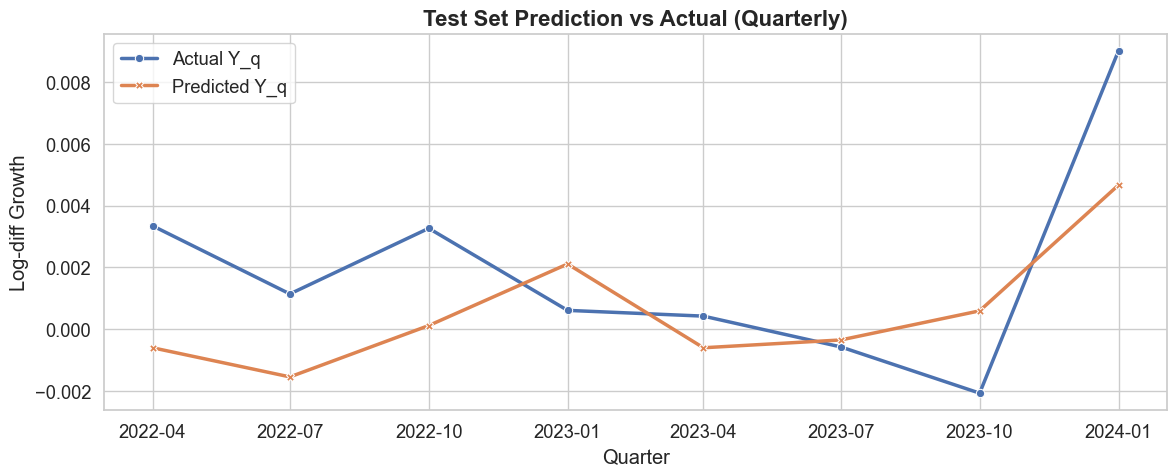

In [6]:
# 5. Quarterly Prediction and Evaluation
y_test_pred = best_model.predict(X_q_test_scaled.values).flatten()

# Define functions for sMAPE and Theil's U1
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)
    return np.mean(ratio) * 100

def theil_u1(y_true, y_pred):
    """Theil's U1 statistic for forecast accuracy"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rms_actual = np.sqrt(np.mean(y_true**2))
    rms_pred = np.sqrt(np.mean(y_pred**2))
    if (rms_actual + rms_pred) == 0:
        return np.nan
    return rmse / (rms_actual + rms_pred)

# Calculate all metrics
mse = mean_squared_error(Y_q_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_q_test, y_test_pred)
r2 = r2_score(Y_q_test, y_test_pred)
sign_acc = (np.sign(y_test_pred) == np.sign(Y_q_test)).mean()
smape_val = smape(Y_q_test, y_test_pred)
theil_u1_val = theil_u1(Y_q_test, y_test_pred)

# Print all metrics
print("\n[Model Evaluation on Test Set]")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²: {r2:.3f}")
print(f"Sign Accuracy: {sign_acc:.2%}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"Theil's U1: {theil_u1_val:.3f}")


# Create a DataFrame for per-prediction results
results_index = Y_q_test.index
results_df = pd.DataFrame({
    "Quarter": results_index.to_timestamp(),
    "Actual_Y_q": Y_q_test,
    "Predicted_Y_q": y_test_pred,
    "Sign_Match": (np.sign(y_test_pred) == np.sign(Y_q_test)).astype(int)
})
results_df.to_csv("test_MLP_UK_VIIRS_solo.csv", index=False)
print("\n'test_MLP_UK_VIIRS_solo.csv' saved.")

# Create and save a DataFrame for the summary metrics
metrics_summary_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Sign Accuracy', 'sMAPE', 'Theil U1'],
    'Value': [mse, rmse, mae, r2, sign_acc, smape_val, theil_u1_val]
})
metrics_summary_df.to_csv("test_MLP_UK_VIIRS_solo_summary_metrics.csv", index=False)
print("'test_MLP_UK_VIIRS_solo_summary_metrics.csv' saved.")

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 5))
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=Y_q_test.values, label="Actual Y_q", marker="o")
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test_pred, label="Predicted Y_q", marker="X")

plt.title("Test Set Prediction vs Actual (Quarterly)", fontsize=16, weight='bold')
plt.xlabel("Quarter")
plt.ylabel("Log-diff Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# 6. Monthly GDP prediction with reconciliation (Proportional Denton)

# Monthly X scaling (matching columns and order used in model training)
X_m_scaled = X_prime_m_df[X_q_train.columns].copy()
if non_log_cols:
    X_m_scaled[non_log_cols] = scaler.transform(X_m_scaled[non_log_cols])

# Monthly "quarterly-perspective" growth prediction
monthly_y_pred_nn = best_model.predict(X_m_scaled.values).flatten()
monthly_predictions_df = pd.DataFrame({
    'raw_quarterly_log_diff_pred': monthly_y_pred_nn
}, index=X_prime_m_df['DATE'])
monthly_predictions_df.index = pd.to_datetime(monthly_predictions_df.index)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# Naive monthly growth: simply distribute predicted quarterly growth equally to each month
monthly_predictions_df['naive_monthly_log_diff'] = monthly_predictions_df['raw_quarterly_log_diff_pred'] / 3.0

# Actual observed quarterly log growth (Y_q_processed)
actual_quarterly_log_diffs = Y_q_processed.copy()
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# For each quarter, calculate scaling factor so the sum of naive monthly growths matches actual quarterly growth
quarterly_sum_of_naive = monthly_predictions_df.groupby('quarter')['naive_monthly_log_diff'].sum()
adjusted_monthly_log_diffs = pd.Series(index=monthly_predictions_df.index, dtype=float)

for quarter, group in monthly_predictions_df.groupby('quarter'):
    if quarter in actual_quarterly_log_diffs.index and quarter in quarterly_sum_of_naive.index:
        actual_q_log_diff = actual_quarterly_log_diffs.loc[quarter]
        sum_naive = quarterly_sum_of_naive.loc[quarter]
        if sum_naive != 0:
            adjustment_factor = actual_q_log_diff / sum_naive
            adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff'] * adjustment_factor
        else:
            # If sum_naive is zero, evenly distribute actual growth across the months in the quarter
            adjusted_monthly_log_diffs.loc[group.index] = actual_q_log_diff / len(group)
    else:
        # If we have no actual value, just use the naive value
        adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff']

monthly_predictions_df['adjusted_monthly_log_diff'] = adjusted_monthly_log_diffs

# Export predicted monthly GDP growth as CSV
mgdp_pred_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff']
}, index=monthly_predictions_df.index)
mgdp_pred_df.index.name = "DATE"
mgdp_pred_df.to_csv("UK_monthly_GDP_MLP_VIIRS_solo_growth.csv")
print("UK_monthly_GDP_MLP_VIIRS_solo_growth.csv saved")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
UK_monthly_GDP_MLP_VIIRS_solo_growth.csv saved


2025-06-26 06:18:13.591214: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-26 06:18:13.591594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

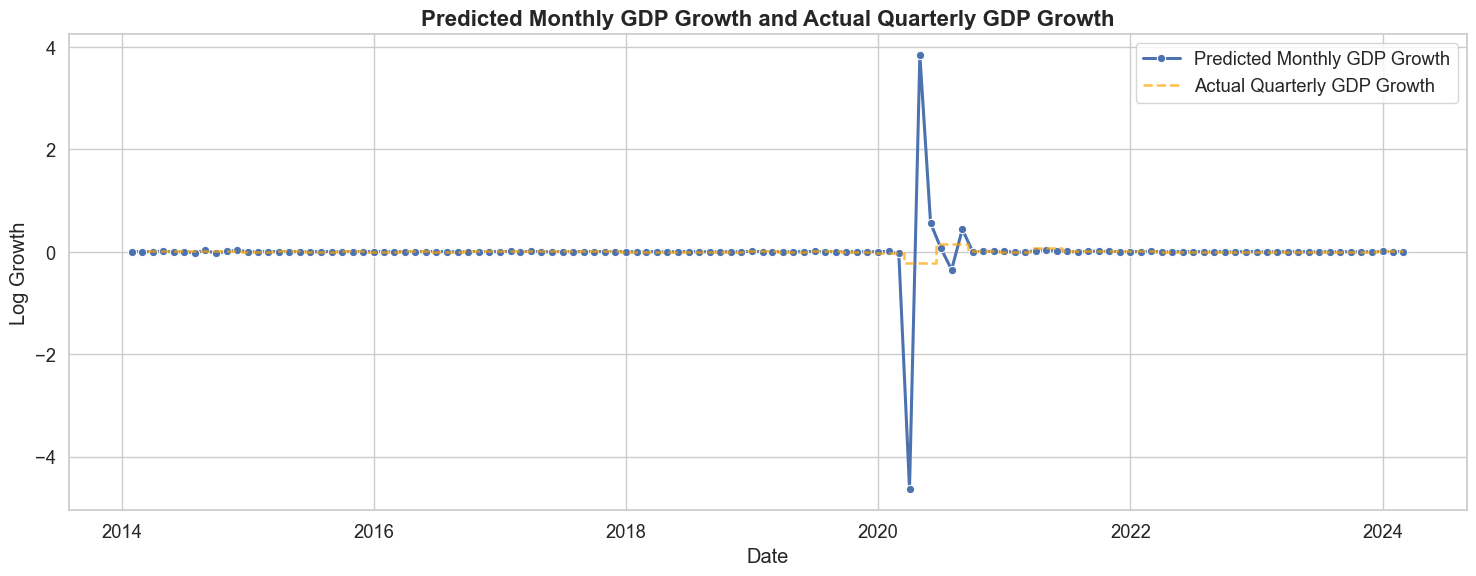

In [8]:
# Plotting Predicted Monthly GDP Growth vs Actual Quarterly GDP Growth
monthly_pred = monthly_predictions_df['adjusted_monthly_log_diff']
quarter_to_growth = actual_quarterly_log_diffs
monthly_actual = monthly_predictions_df['quarter'].map(quarter_to_growth)

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_pred.index, y=monthly_pred.values, label="Predicted Monthly GDP Growth", marker='o', linewidth=2.2)
plt.step(monthly_actual.index, monthly_actual.values, label="Actual Quarterly GDP Growth",
         where='mid', linestyle='--', color='orange', linewidth=1.8, alpha=0.7)

plt.title("Predicted Monthly GDP Growth and Actual Quarterly GDP Growth", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Log Growth")
plt.legend()
plt.tight_layout()
plt.show()

Base quarter not found. Using the first available GDP level 2014Q1: 554183.0
Final quarterly comparison results:
            Actual_Quarterly_Level  ReAgg_Monthly_Level
quarter                                                
2014-01-01                554183.0        554183.000000
2014-04-01                559331.0        555763.850129
2014-07-01                563694.0        558480.722331
2014-10-01                567619.0        545228.875533
2015-01-01                569150.0        567994.559858

R²: -4.7463, MSE: 5624958771.75


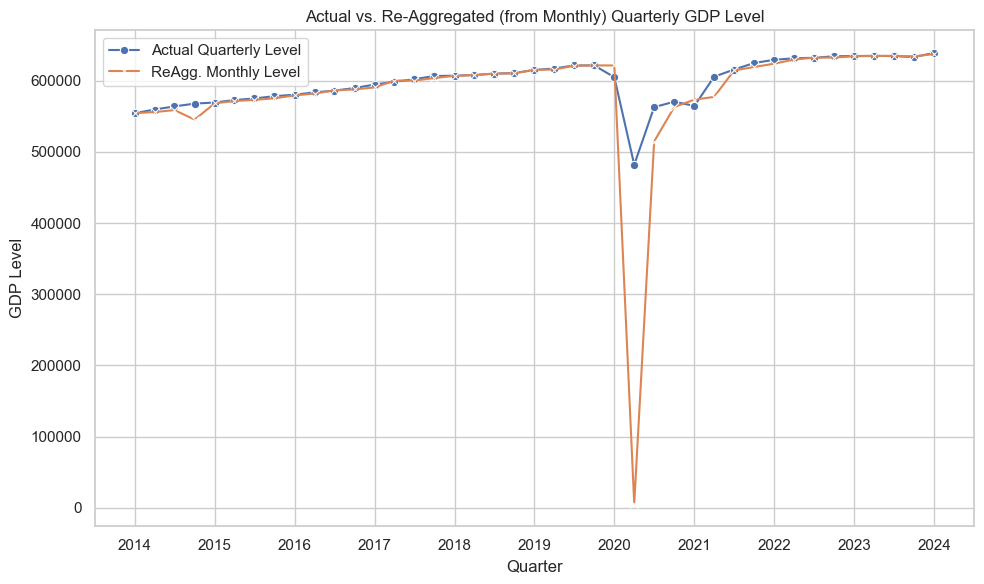

UK_monthly_GDP_MLP_VIIRS_solo_growth_level.csv saved!


In [9]:
# 7. Recover Monthly Level

# Find the first valid index (start month) for growth reconstruction
first_valid_month_idx = monthly_predictions_df['adjusted_monthly_log_diff'].first_valid_index()
first_quarter = monthly_predictions_df.loc[first_valid_month_idx, 'quarter']
base_level_quarter = first_quarter - 1

# Set base_level as the previous quarter's GDP level
if base_level_quarter in Y_q_levels.index:
    base_level = Y_q_levels.loc[base_level_quarter]
    print(f"Using GDP level of base quarter {base_level_quarter} as base_level: {base_level}")
else:
    base_level = Y_q_levels.iloc[0]
    print(f"Base quarter not found. Using the first available GDP level {Y_q_levels.index[0]}: {base_level}")

# Recover monthly GDP levels from growth (starting from the first valid growth)
reconstructed_levels = {}
current_level = base_level
for i, month in enumerate(monthly_predictions_df.index):
    if month < first_valid_month_idx:
        reconstructed_levels[month] = np.nan
    elif month == first_valid_month_idx:
        reconstructed_levels[month] = current_level
    else:
        log_diff = monthly_predictions_df.loc[month, 'adjusted_monthly_log_diff']
        if pd.isna(log_diff):
            reconstructed_levels[month] = np.nan
        else:
            prev_month = monthly_predictions_df.index[monthly_predictions_df.index.get_loc(month) - 1]
            prev_level = reconstructed_levels[prev_month]
            if pd.isna(prev_level):
                reconstructed_levels[month] = np.nan
            else:
                reconstructed_levels[month] = prev_level * np.exp(log_diff)
monthly_predictions_df['reconstructed_monthly_level'] = pd.Series(reconstructed_levels)


# Aggregate to Quarterly Level & Compare with Actual (using first month of each quarter)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')
re_agg_quarterly = (
    monthly_predictions_df
    .groupby('quarter')['reconstructed_monthly_level']
    .first()
)

# Convert index to Timestamp for plotting
re_agg_quarterly_ts = re_agg_quarterly.copy()
re_agg_quarterly_ts.index = re_agg_quarterly_ts.index.to_timestamp(how='start')
Y_q_levels_ts = Y_q_levels.copy()
Y_q_levels_ts.index = Y_q_levels_ts.index.to_timestamp(how='start')

comparison_df = pd.DataFrame({
    'Actual_Quarterly_Level': Y_q_levels_ts,
    'ReAgg_Monthly_Level': re_agg_quarterly_ts
}).dropna()

print("Final quarterly comparison results:")
print(comparison_df.head())
print("\nR²: %.4f, MSE: %.2f" % (
    r2_score(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level']),
    mean_squared_error(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level'])
))


# Plot 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(x=comparison_df.index, y=comparison_df['Actual_Quarterly_Level'], marker='o', label='Actual Quarterly Level')
sns.lineplot(x=comparison_df.index, y=comparison_df['ReAgg_Monthly_Level'], marker='x', label='ReAgg. Monthly Level')
plt.title("Actual vs. Re-Aggregated (from Monthly) Quarterly GDP Level")
plt.xlabel("Quarter")
plt.ylabel("GDP Level")
plt.legend()
plt.tight_layout()
plt.show()


# Save monthly GDP growth and level to CSV
out_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff'],
    "MGDP_level_pred": monthly_predictions_df['reconstructed_monthly_level']
}, index=monthly_predictions_df.index)
out_df.index.name = "DATE"
out_df.to_csv("UK_monthly_GDP_MLP_VIIRS_solo_growth_level.csv")
print("UK_monthly_GDP_MLP_VIIRS_solo_growth_level.csv saved!")